In [1]:
#visualize the burst matting dataset
from utils.image.synthesis_helper import apply_flow_field
from dataset.synthetic_burst import SyntheticBurstDataset
from utils.image.rgb2raw import process_linear_image_raw
from torchvision.utils import make_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch
import gin
gin.parse_config_file('configs/matting/image2burst.gin')
dataset = SyntheticBurstDataset()
data = dataset[0]

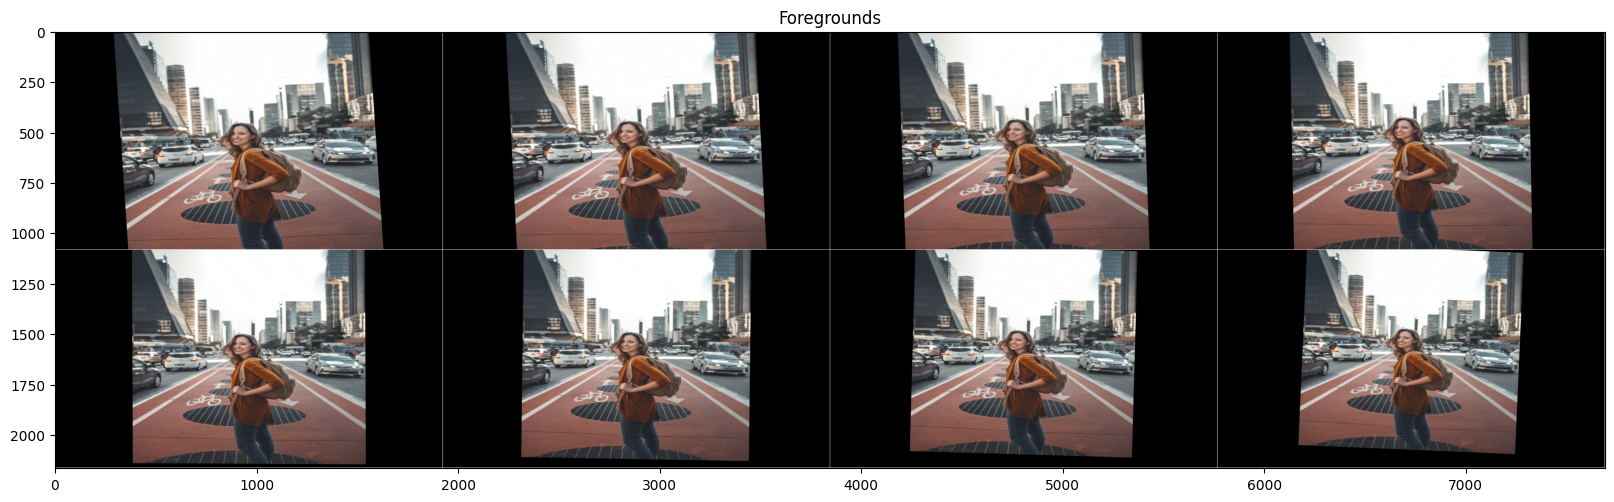

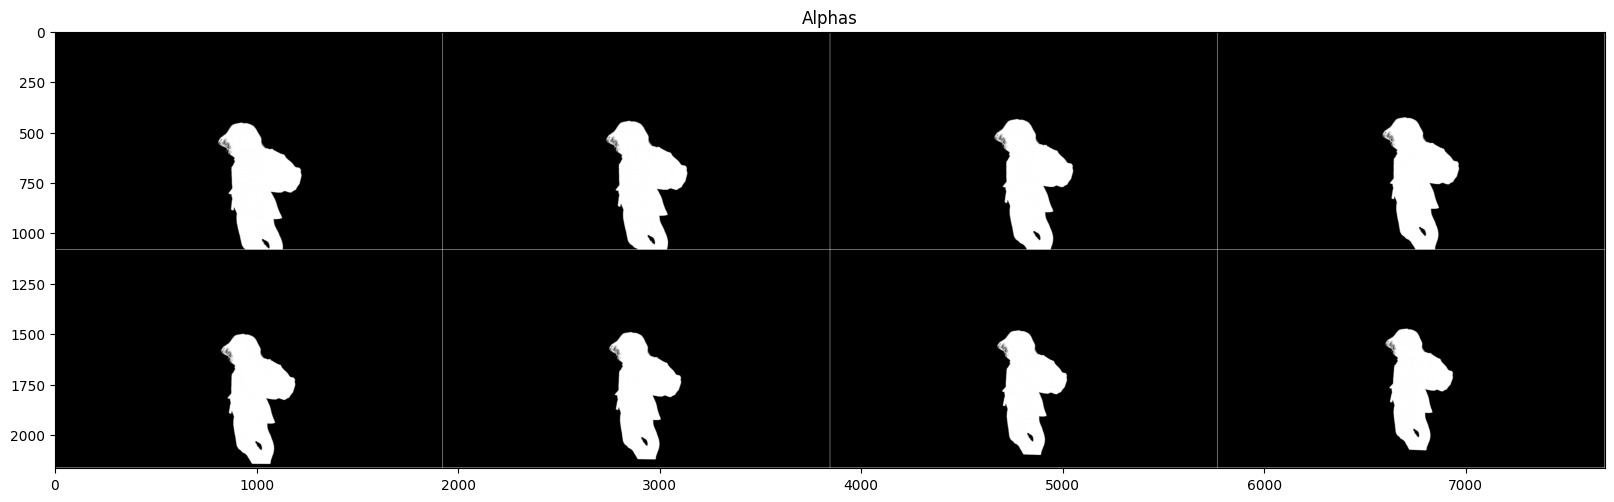

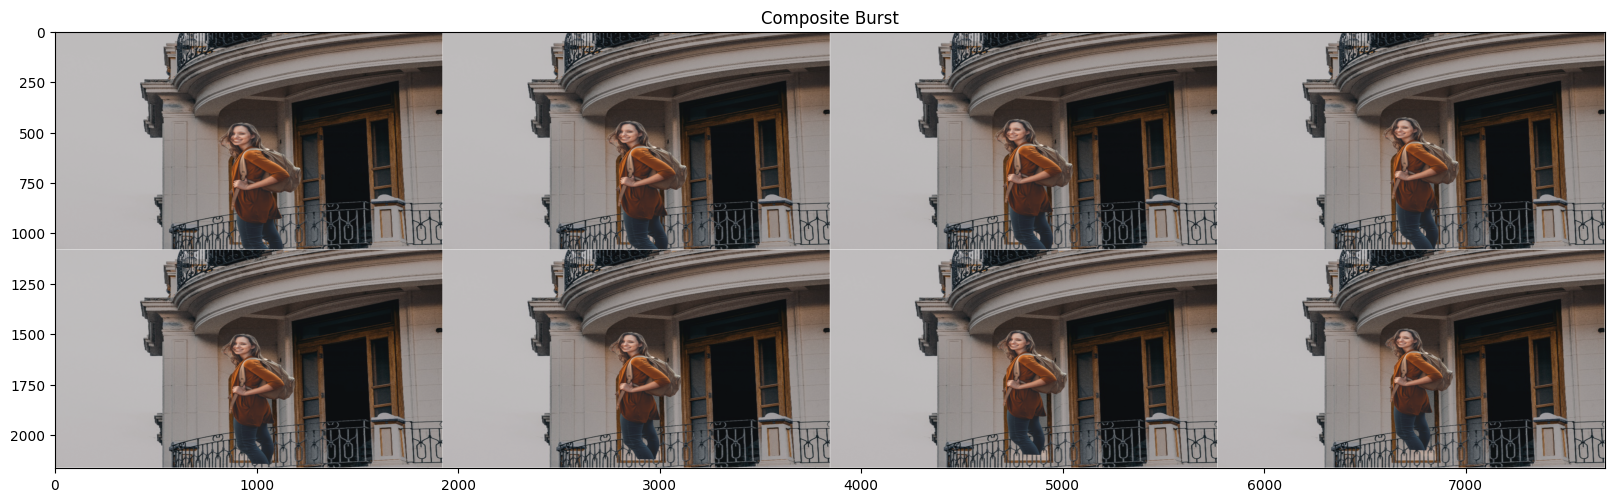

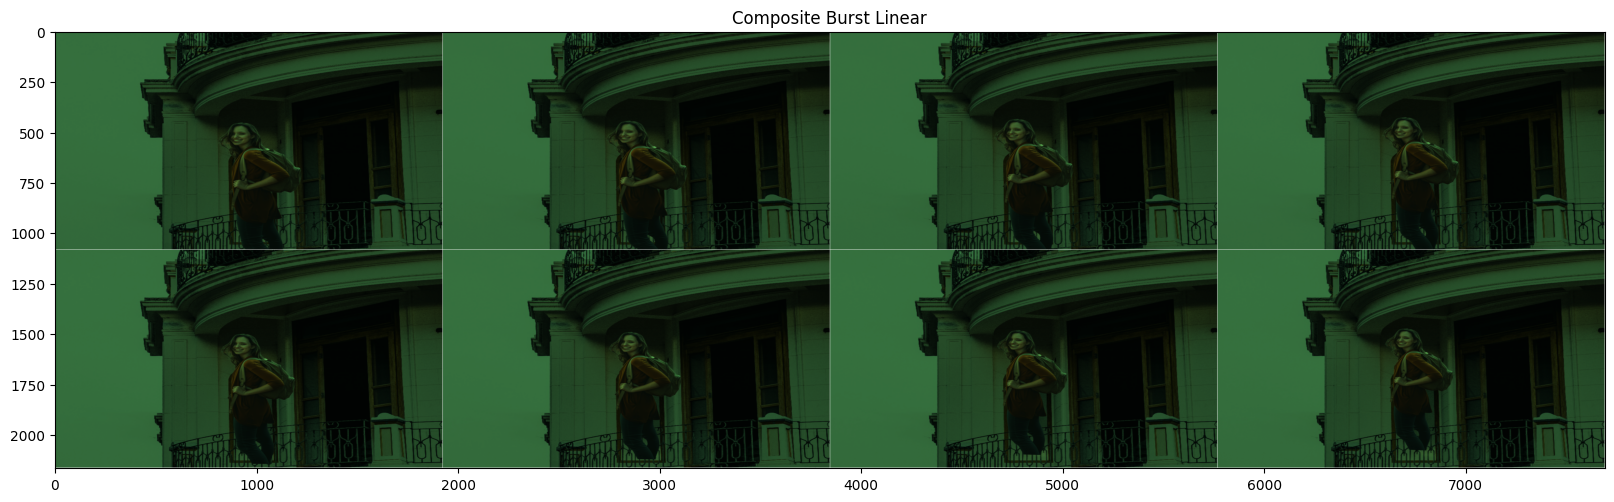

In [2]:
#visualize the burst images, fgrs_gamma, and alphas
fgrs_gamma = data['fgrs_gamma']
plt.figure(figsize=(20, 16))
grid = make_grid(fgrs_gamma, nrow=4, padding=2, pad_value=1)
plt.title('Foregrounds')
plt.imshow(transforms.ToPILImage()(grid))
alphas = data['alpha_burst']
plt.figure(figsize=(20, 16))
grid = make_grid(alphas, nrow=4, padding=2, pad_value=1)
plt.title('Alphas')
plt.imshow(transforms.ToPILImage()(grid))
comp_burst_gamma = data['comp_burst_gamma']
plt.figure(figsize=(20, 16))
grid = make_grid(comp_burst_gamma, nrow=4, padding=2, pad_value=1)
plt.title('Composite Burst')
plt.imshow(transforms.ToPILImage()(grid))
comp_burst = data['comp_burst']
plt.figure(figsize=(20, 16))
grid = make_grid(comp_burst, nrow=4, padding=2, pad_value=1)
plt.title('Composite Burst Linear')
plt.imshow(transforms.ToPILImage()(grid))


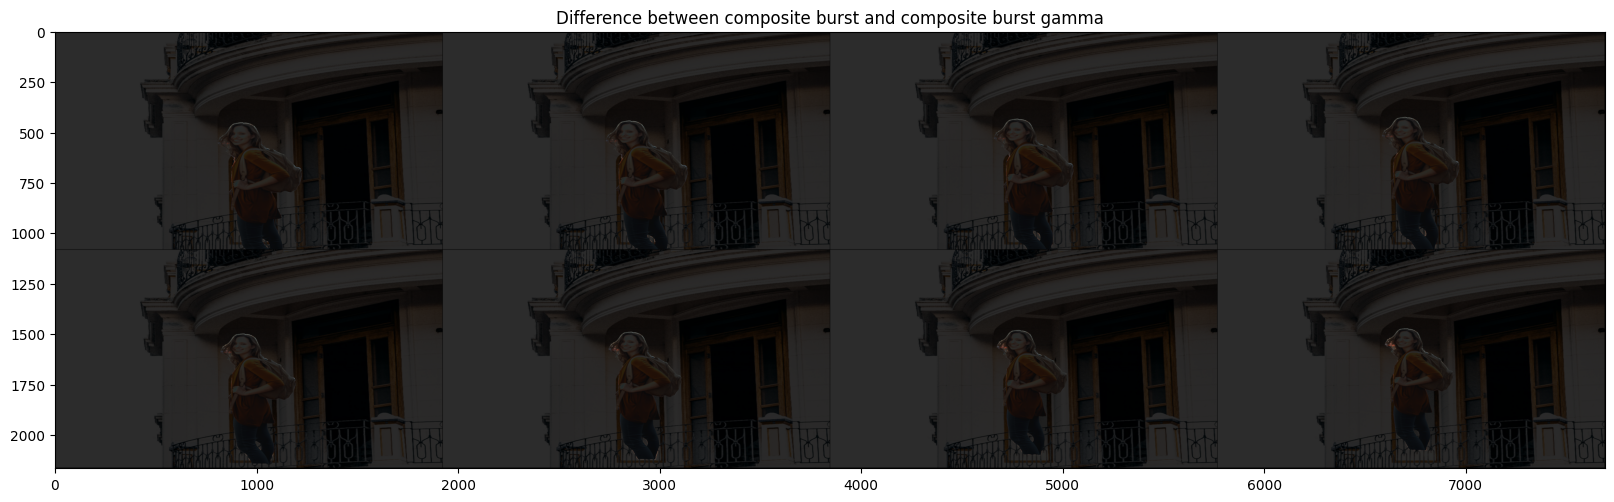

In [3]:
#visualize the difference between the composite burst and the composite burst gamma
data["unprocess_metadata"]["cam2rgb"] = data["unprocess_metadata"]["cam2rgb"][:8]
comp_burst = process_linear_image_raw(comp_burst, data["unprocess_metadata"],apply_demosaic=False)
diff = torch.abs(comp_burst - data["comp_burst_gamma"])
plt.figure(figsize=(20, 16))
diff_grid = make_grid(diff, nrow=4, padding=2, normalize=True)
plt.title('Difference between composite burst and composite burst gamma')
plt.imshow(transforms.ToPILImage()(diff_grid))

<Figure size 100000x80000 with 0 Axes>

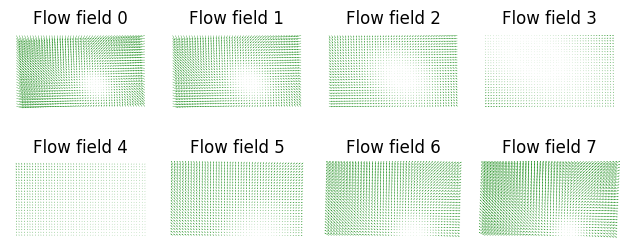

/sensei-fs/users/xcai/conda/envs/rvm/lib/python3.8/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


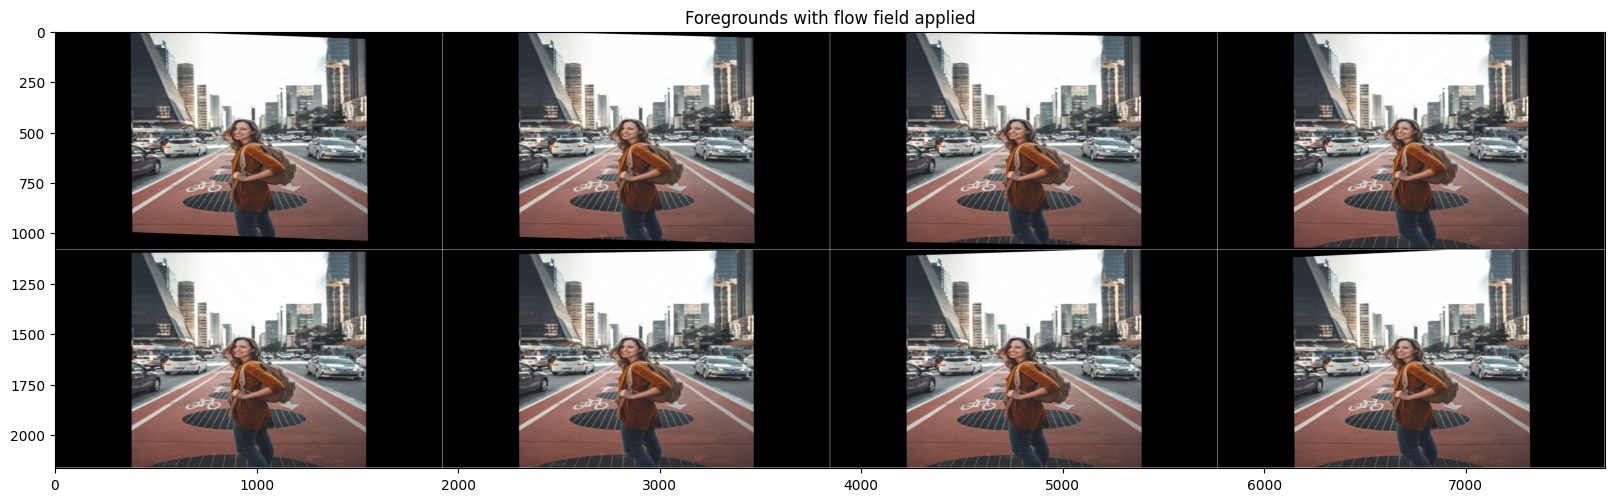

In [4]:
# visualize the flow field
fgr_flow_fields = data["motion_metadata"]["fgr_flow_fields"]
plt.figure(figsize=(100, 80), dpi=1000)
fig, axs = plt.subplots(2, 4)
step = 40 # step size for the flow field
reference_flow_field = fgr_flow_fields[0].clone()
for i, fgr_flow_field in enumerate(fgr_flow_fields):
    fgr_flow_field = fgr_flow_field - reference_flow_field
for i, fgr_flow_field in enumerate(fgr_flow_fields):
    flow = fgr_flow_field.permute(1, 2, 0).numpy()
    u = flow[..., 0]
    v = flow[..., 1]
    w = u.shape[1]
    h = u.shape[0]
    x_grid, y_grid = np.meshgrid(np.arange(w), np.arange(h))
    axs[i//4, i%4].quiver(x_grid[::step, ::step], y_grid[::step, ::step], u[::step, ::step], v[::step, ::step], angles='xy', scale_units='xy', scale=1, color='g')
    axs[i//4, i%4].set_title(f'Flow field {i}')
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].set_aspect('equal')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=-0.7)
plt.tight_layout()
plt.show()
# visualize the flow field applied to the foreground
fgrs_linear_apply_flow = []
for i, fgr_gamma in enumerate(fgrs_gamma):
    fgr_flow_field = fgr_flow_fields[i]
    fgrs_linear_apply_flow.append(apply_flow_field(fgr_gamma, -fgr_flow_field))
plt.figure(figsize=(20, 16))
grid = make_grid(fgrs_linear_apply_flow, nrow=4, padding=2, pad_value=1)
plt.title('Foregrounds with flow field applied')
plt.imshow(transforms.ToPILImage()(grid))


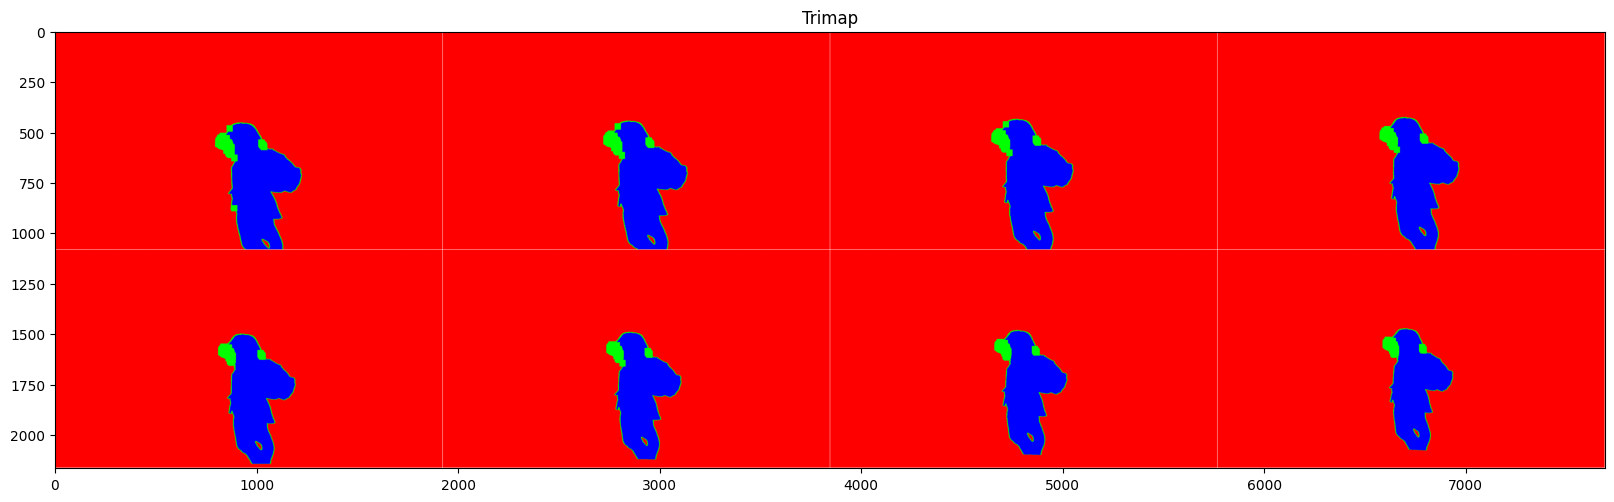

In [5]:
#visualize the trimap of the data
trimap_burst = data["trimap_burst"]
plt.figure(figsize=(20, 16))
grid = make_grid(trimap_burst, nrow=4, padding=2, pad_value=1)
plt.title('Trimap')
plt.imshow(transforms.ToPILImage()(grid))

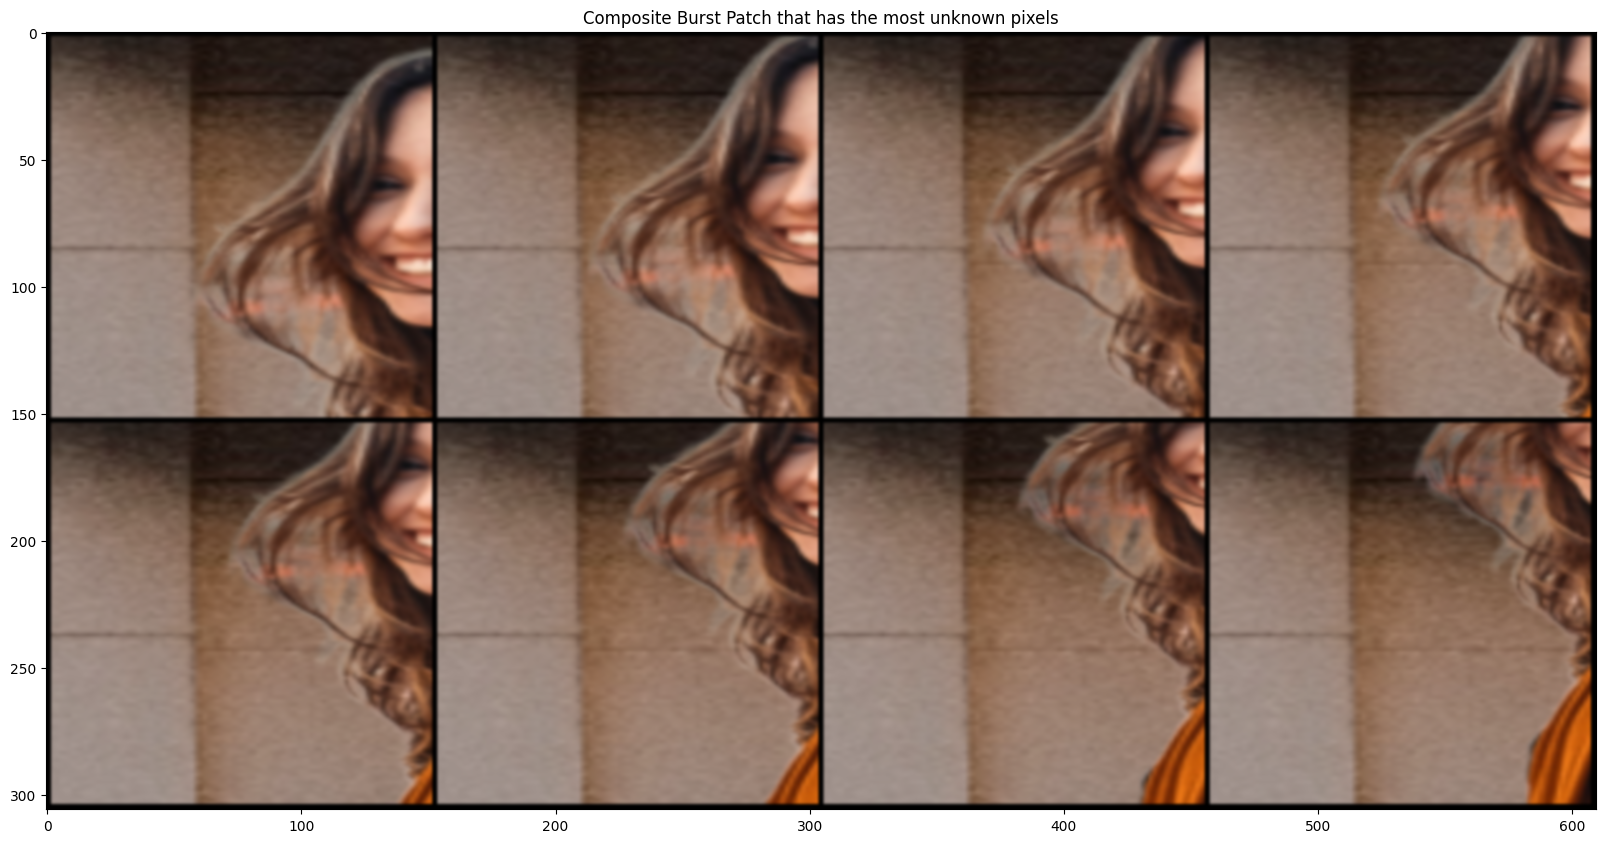

In [6]:
#visualize the patches of the data
from dataset.synthetic_burst import SyntheticBurstPatch
dataset_patches = SyntheticBurstPatch(patch_size = 150)
for k in ('fgrs_linear', 'bgrs_linear', 'alpha_burst', 'comp_burst', 'trimap_burst'):
    if k in data:
        data[k + "_patch"] = dataset_patches.split_into_patches(data[k], dataset_patches.patch_size, padding_mode='constant')

trimap_burst_patch = data["trimap_burst_patch"]
sum_list = []
for i in range(trimap_burst_patch.shape[0]):
    sum_list.append(torch.sum(trimap_burst_patch[i,:,1]))
# print(sum_list)
i = np.argmax(sum_list)
# i = 44
# print(i)
plt.figure(figsize=(20,12))
comp_burst_patch = process_linear_image_raw(data["comp_burst_patch"][i], data["unprocess_metadata"],apply_demosaic=False)
grid = make_grid(comp_burst_patch, nrow=4, padding=2, normalize=True)

plt.title('Composite Burst Patch that has the most unknown pixels')
plt.imshow(transforms.ToPILImage()(grid), interpolation="bicubic", aspect=1)

<Figure size 10000x8000 with 0 Axes>

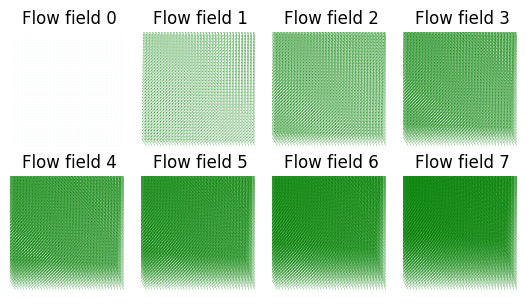

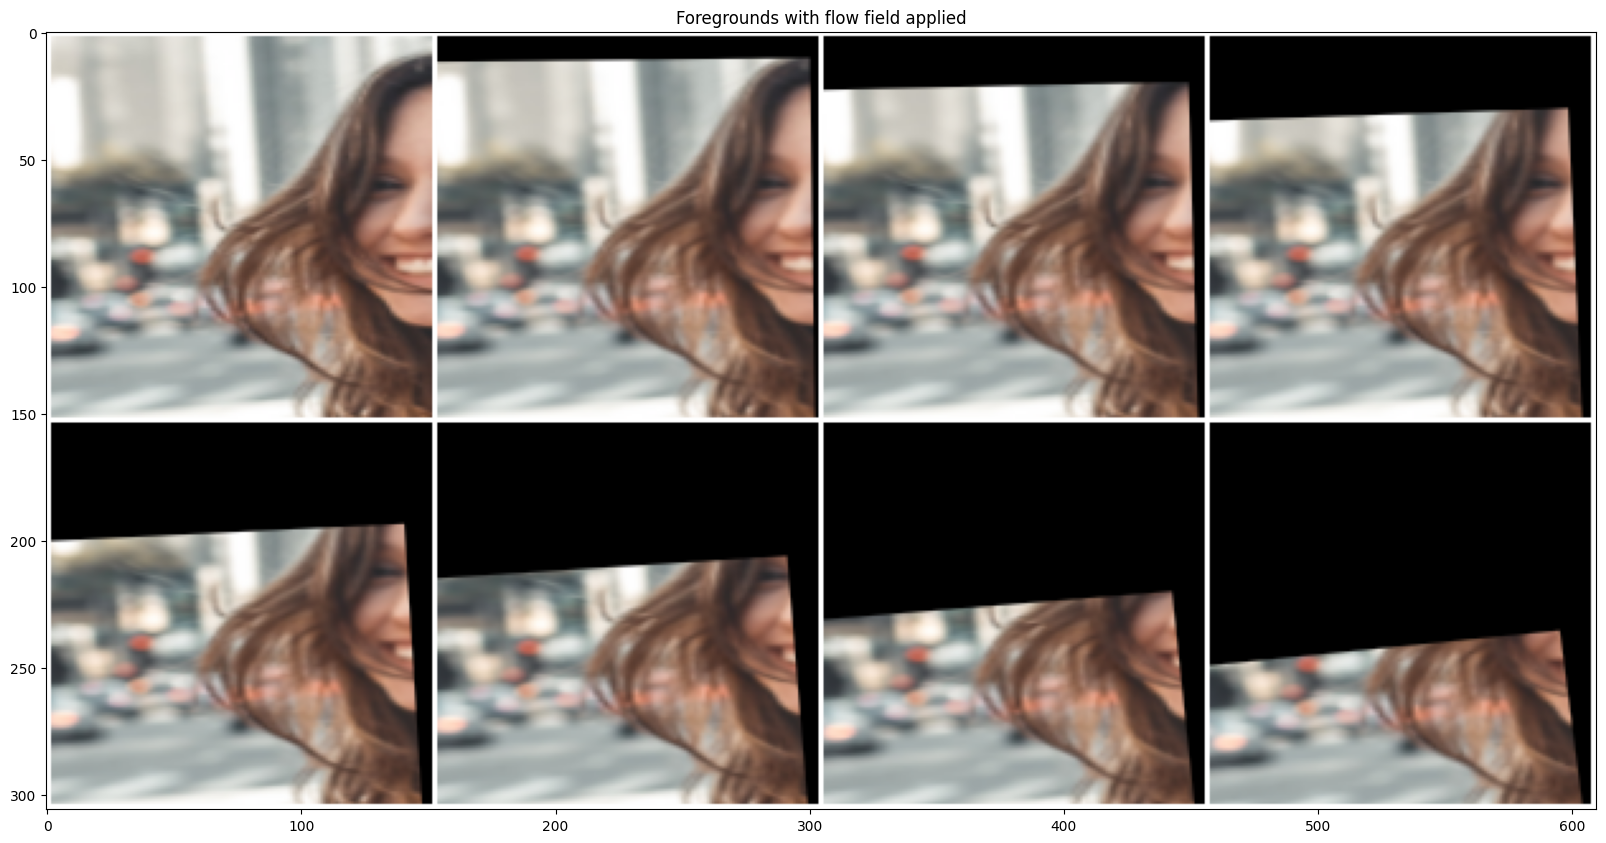

In [7]:
# visualize the flow field patches
flow_fields = data["motion_metadata"]["fgr_flow_fields"]
flow_fields = torch.stack(flow_fields).clone()
flow_fields_patch = dataset_patches.split_into_patches(flow_fields, dataset_patches.patch_size, padding_mode='constant')
plt.figure(figsize=(10, 8), dpi=1000)
fig, axs = plt.subplots(2, 4)
flow_fields_patch = flow_fields_patch[i].clone()
reference_flow_field = flow_fields_patch[0].clone()
for flow_field_patch in flow_fields_patch:
    flow_field_patch -= reference_flow_field

step = 4 # step size for the flow field
fgrs_linear_patch = process_linear_image_raw(data["fgrs_linear_patch"][i], data["unprocess_metadata"],apply_demosaic=False)
fgrs_linear_patch = fgrs_linear_patch.clone()
for i, flow_field_patch in enumerate(flow_fields_patch):
    
    flow_field = flow_field_patch.permute(1, 2, 0).numpy()
    u = flow_field[..., 0]
    v = flow_field[..., 1]
    w = u.shape[1]
    h = u.shape[0]
    x_grid, y_grid = np.meshgrid(np.arange(w), np.arange(h))
    axs[i//4, i%4].quiver(x_grid[::step, ::step], y_grid[::step, ::step], u[::step, ::step], v[::step, ::step], angles='xy', scale_units='xy', scale=1, color='g')
    axs[i//4, i%4].set_title(f'Flow field {i}')
    axs[i//4, i%4].axis('off')
    axs[i//4, i%4].set_aspect('equal')
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.1, hspace=-0.4)
plt.show()
# visualize the flow field applied to the foreground
fgrs_patch_apply_flow = []
for i, fgr_gamma_patch in enumerate(fgrs_linear_patch):
    fgr_flow_field_patch = flow_fields_patch[i]
    result = apply_flow_field(fgr_gamma_patch, -fgr_flow_field_patch)
    fgrs_patch_apply_flow.append(result)
# print(len(fgrs_patch_apply_flow))
plt.figure(figsize=(20, 16))
grid = make_grid(fgrs_patch_apply_flow, nrow=4, padding=2, pad_value=1)
plt.title('Foregrounds with flow field applied')
plt.imshow(transforms.ToPILImage()(grid))